In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
train = pd.read_csv('files/train.csv')

## The PassengerId is directly related to the index..

In [4]:
all(train.index == train.PassengerId - 1)

True

# Looking at the data...

## Any missing values?

In [5]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [6]:
train.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

## Age has missing values. Let's look at it. 

(array([ 54.,  46., 177., 169., 118.,  70.,  45.,  24.,   9.,   2.]),
 array([ 0.42 ,  8.378, 16.336, 24.294, 32.252, 40.21 , 48.168, 56.126,
        64.084, 72.042, 80.   ]),
 <BarContainer object of 10 artists>)

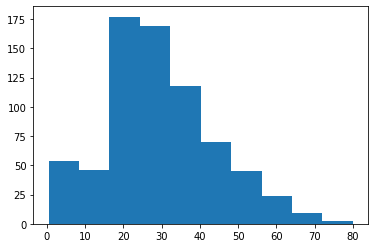

In [7]:
plt.hist(train['Age'])

## The data here is vaguely Gaussian. The choice of the median or mean in this case would offer the 'most common' age, which can be an appropriate choice to fill the missing values. However, it's not a painfully realistic assumption to assume that the missing passenger ages are all the same, so what I'll do instead is give them ages from a normal distribution centered on the 'most common' age.

In [8]:
med = np.nanmedian(train['Age'])
mean = np.nanmean(train['Age'])

In [9]:
nans = train[train.Age.isna()]
nans

PassengerId  Survived  Pclass                                      Name  \
5              6         0       3                          Moran, Mr. James   
17            18         1       2              Williams, Mr. Charles Eugene   
19            20         1       3                   Masselmani, Mrs. Fatima   
26            27         0       3                   Emir, Mr. Farred Chehab   
28            29         1       3             O'Dwyer, Miss. Ellen "Nellie"   
..           ...       ...     ...                                       ...   
859          860         0       3                          Razi, Mr. Raihed   
863          864         0       3         Sage, Miss. Dorothy Edith "Dolly"   
868          869         0       3               van Melkebeke, Mr. Philemon   
878          879         0       3                        Laleff, Mr. Kristo   
888          889         0       3  Johnston, Miss. Catherine Helen "Carrie"   

        Sex  Age  SibSp  Parch      Ticket     Fare Cabin Embarked  
5      male  NaN      0      0      330877   8.4583   NaN        Q  
17     male  NaN      0      0      244373  13.0000   NaN        S  
19   female  NaN      0      0        2649   7.2250   NaN        C  
26     male  NaN      0      0        2631   7.2250   NaN        C  
28   female  NaN      0      0      330959   7.8792   NaN        Q  
..      ...  ...    ...    ...         ...      ...   ...      ...  
859    male  NaN      0      0        2629   7.2292   NaN        C  
863  female  NaN      8      2    CA. 2343  69.5500   NaN        S  
868    male  NaN      0      0      345777   9.5000   NaN        S  
878    male  NaN      0      0      349217   7.8958   NaN        S  
888  female  NaN      1      2  W./C. 6607  23.4500   NaN        S  

[177 rows x 12 columns]

## I see a lot of Pclass = 3. Is the data missing at random?

(array([ 30.,   0.,   0.,   0.,   0.,  11.,   0.,   0.,   0., 136.]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <BarContainer object of 10 artists>)

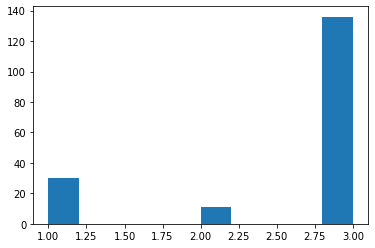

In [10]:
plt.hist(nans['Pclass'])

## It seems the data isn't missing at random, and instead the vast majority of missing ages belong to people with ticket class 3. Since the data isn't missing at random, adding 'fake' ages is probably not worth the effort, as I'd need to make sure the ages I sample from are particularly justified for ticket class 3 peoples' ages, and that would be a smaller subset of values to try and approximate to a normal distribution. I can try and remedy this by taking different cases..

Looking at the titles of the person, the ticket class, the sex, etc, and using the medians/means of all of these to try and ascertain the age.

# Let's look at the data a little bit.

In [11]:
train = train.reset_index(drop = True)

In [12]:
train['PassengerId'] = range(1,len(train.index)+1)
train['Died'] = 1 - train['Survived']

In [13]:
for cols in train.columns:
    print('There are ', len(set(train[cols])), 'unique values for column ', cols)

There are  891 unique values for column  PassengerId
There are  2 unique values for column  Survived
There are  3 unique values for column  Pclass
There are  891 unique values for column  Name
There are  2 unique values for column  Sex
There are  265 unique values for column  Age
There are  7 unique values for column  SibSp
There are  7 unique values for column  Parch
There are  681 unique values for column  Ticket
There are  248 unique values for column  Fare
There are  148 unique values for column  Cabin
There are  4 unique values for column  Embarked
There are  2 unique values for column  Died


# Let's look at the columns without too many unique values, which are likely to be categorical.

In [14]:
fig, axs = plt.subplots(ncols=3, nrows = 2, figsize=(30, 20))
for fig, i,col in zip([0,0,0,1,1,1],[0,1,2,0,1,2],['Pclass','Sex','SibSp','Parch','Embarked','Fare']):
    print(fig,i,col)
    if col == 'Fare':
        max_fare = np.max(train['Fare'])
        plt.hist(train[train['Survived'] == 0]['Fare'], 
         stacked=True,
         bins = 50)
        plt.xticks([0, 0.05*max_fare, 0.1*max_fare, 0.15*max_fare, 0.2*max_fare, 0.25*max_fare])
        plt.title('Mortality by '+col)
        plt.xlim([0,0.25*max_fare])
        plt.xlabel('Fare')
        plt.show()


    train.groupby(col).sum()['Died'].plot(kind = 'bar', ax = axs[fig][i])
    axs[fig][i].set_title('Mortality by '+col)

    i += 1

0 0 Pclass
0 1 Sex
0 2 SibSp
1 0 Parch
1 1 Embarked
1 2 Fare


## Looking at the plots..
- Clearly ticket class 3 had the most deaths.
- Males died far more often than females.
- People with no siblings or spouses on board were most likely to die. 
- People with no parents or children aboard were most likely to die.
- People who had Southamptom as a port of embarkation were most likely to die.
- People who had a lower ticket fare were more likely to die (I'm not displaying the whole range of the Fare histogram but the whole range keeps this relationship)

In [15]:
train['Family members'] = train['Parch'] + train['SibSp']

In [16]:
train.groupby('Family members').sum()['Died'].plot(kind = 'bar')

<AxesSubplot:xlabel='Family members'>

## So, generally speaking, having family members on board seemed to greatly increase a passenger's chance of survival.

# Now, let's work on cleaning the data up, row-by-row.
- Just by looking at its values, Pclass and Embarked should be one-hot encoded.
- It may be worth looking at the titles of passengers, as they're given, and seeing if they could be useful. 
- Using Ticket and Cabin will require a bit of clever thinking to use them properly. We don't have a lot of rows, so one-hot encoding can't be abused too much or our number of dimensions will get too close to our number of datapoints.

# Processing names
## I found a list of honorifics online. I made some functions to clean the names up and test to see if I'm missing any. Any functions I have can be found in the `data_preprocessing` folder.

In [17]:
from data_preprocessing.process_names import append_honorifics

In [19]:
train = append_honorifics(train)

NameError: name 'train' is not defined

In [ ]:
train.iloc[5]

Survived       0.0000
Age           26.0000
SibSp          0.0000
Parch          0.0000
Fare           8.4583
Mr             1.0000
Mrs               NaN
Miss              NaN
Master            NaN
Don               NaN
Rev               NaN
Dr                NaN
Mme               NaN
Ms                NaN
Major             NaN
Lady              NaN
Sir               NaN
Mlle              NaN
Col               NaN
Capt              NaN
Countess          NaN
Sex_female     0.0000
Sex_male       1.0000
Pclass_1       0.0000
Pclass_2       0.0000
Pclass_3       1.0000
Embarked_C     0.0000
Embarked_Q     1.0000
Embarked_S     0.0000
Name: 5, dtype: float64

## It looks like there're a few weird honorifics. I'll add them and check again.

## Looks like the list is good now. I'm now going to append these honorifics to the dataset.

In [ ]:
train = train.drop(columns = ['Died', 'Family members'])

# Dealing with missing ages

## My way with dealing with the nan ages was as follows:

- I needed to treat the missing values with care, because they didn't seem to be missing randomly -- most of the ones missing had a ticket class of 3, for example
- Therefore, take identifying passenger information (gender, ticket class and title), and take a subset of the dataset with passengers who also share those attributes
- Take the mean or median age of that population. The choice of the mean or median will come down to using the mean if the distribution passes a normality test with alpha = 1e-3, and the median otherwise. If there are too few samples with which to take a normality test for the population, see how close the mean and median are. If they're close, within 10% of eachother, just take the mean. If not, take the median since that usually implies the histogram is skewed.

With every couple of iterations I'll show an age histogram of the relevant population the person who's age is NaN.

Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  31 for  male with pclass  2 and title  Mr
Changing  nan to  34 for  female with pclass  3 and title  Mrs
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  41 for  female with pclass  1 and title  Mrs
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  42 for  male with pclass  1 and title  Mr
Changing  nan to  42 for  male with pclass  1 and title  Mr
Changing  nan to  5 fo

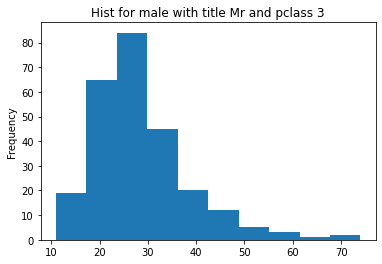

Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  34 for  female with pclass  3 and title  Mrs
Changing  nan to  42 for  male with pclass  1 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  34 for  female with pclass  3 and title  Mrs
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  41 for  female with pclass  1 and title  Mrs
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  31 for  male with pclass  2 and title  Mr
Changing  nan t

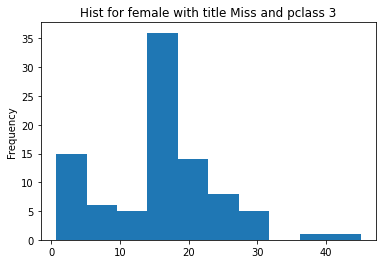

Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr


Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  34 for  female with pclass  3 and title  Mrs
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  22 for  female with pclass  2 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  42 for  male with pclass  1 and title  Mr


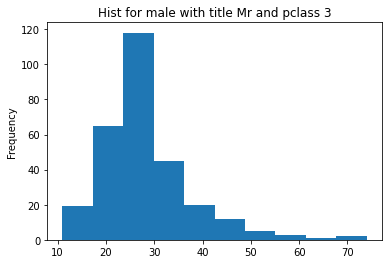

Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr


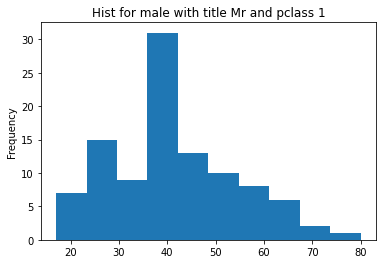

Changing  nan to  42 for  male with pclass  1 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  41 for  female with pclass  1 and title  Mrs
Changing  nan to  31 for  male with pclass  2 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss
Changing  nan to  5 for  male with pclass  3 and title  Master
Changing  nan to  42 for  male with pclass  1 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 f

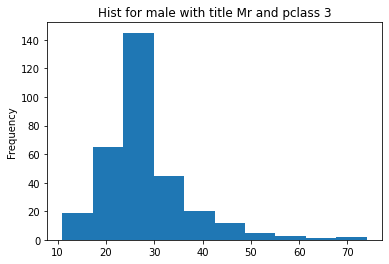

Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  26 for  male with pclass  3 and title  Mr
Changing  nan to  16 for  female with pclass  3 and title  Miss


In [ ]:
from data_preprocessing.fill_in_ages import fill_in_nan_ages

train = fill_in_nan_ages(train)

## And to check that we have no more missing age values..

In [ ]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.138238    0.523008   
std     257.353842    0.486592    0.836071   13.596951    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.000000    0.000000   
50%     446.000000    0.000000    3.000000   26.000000    0.000000   
75%     668.500000    1.000000    3.000000   36.750000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare     Mr    Mrs   Miss  ...   Dr  Mme   Ms  Major  \
count  891.000000  891.000000  518.0  129.0  182.0  ...  7.0  1.0  1.0    2.0   
mean     0.381594   32.204208    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   
std      0.806057   49.693429    0.0    0.0    0.0  ...  0.0  NaN  NaN    0.0   
min      0.000000    0.000000    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   
25%      0.000000    7.910400    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   
50%      0.000000   14.454200    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   
75%      0.000000   31.000000    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   
max      6.000000  512.329200    1.0    1.0    1.0  ...  1.0  1.0  1.0    1.0   

       Lady  Sir  Mlle  Col  Capt  Countess  
count   1.0  1.0   2.0  2.0   1.0       1.0  
mean    1.0  1.0   1.0  1.0   1.0       1.0  
std     NaN  NaN   0.0  0.0   NaN       NaN  
min     1.0  1.0   1.0  1.0   1.0       1.0  
25%     1.0  1.0   1.0  1.0   1.0       1.0  
50%     1.0  1.0   1.0  1.0   1.0       1.0  
75%     1.0  1.0   1.0  1.0   1.0       1.0  
max     1.0  1.0   1.0  1.0   1.0       1.0  

[8 rows x 23 columns]

## Dealing with Ticket and Cabin

In [ ]:
train.Cabin.isna().sum()

687

Ticket and Cabin are very unwieldy columns. There are some resources online saying Ticket has meaning, but I'd then have to think about how I'd deal with the data -- it couldn't be considered categorical. I'm going to elect to discard it.

Cabin, meanwhile, has most of its values a NaN, so I'm going to drop it, as I couldn't really justify filling those NaNs with something. I'm also going to drop Died, because I'm not using it anymore. I'm also going to drop PassengerId because it's redundant.

In [ ]:
train = train.drop(columns = ['Ticket','Cabin', 'PassengerId', 'Name','title'])

## Now to one-hot encode the obvious columns: Sex, Pclass and Embarked.

In [ ]:
train=pd.get_dummies(train, columns = ['Sex', 'Pclass','Embarked'])

## Here's how the data looks now.

In [ ]:
train

Survived   Age  SibSp  Parch     Fare   Mr  Mrs  Miss  Master  Don  ...  \
0           0  22.0      1      0   7.2500  1.0  NaN   NaN     NaN  NaN  ...   
1           1  38.0      1      0  71.2833  NaN  1.0   NaN     NaN  NaN  ...   
2           1  26.0      0      0   7.9250  NaN  NaN   1.0     NaN  NaN  ...   
3           1  35.0      1      0  53.1000  NaN  1.0   NaN     NaN  NaN  ...   
4           0  35.0      0      0   8.0500  1.0  NaN   NaN     NaN  NaN  ...   
..        ...   ...    ...    ...      ...  ...  ...   ...     ...  ...  ...   
886         0  27.0      0      0  13.0000  NaN  NaN   NaN     NaN  NaN  ...   
887         1  19.0      0      0  30.0000  NaN  NaN   1.0     NaN  NaN  ...   
888         0  16.0      1      2  23.4500  NaN  NaN   1.0     NaN  NaN  ...   
889         1  26.0      0      0  30.0000  1.0  NaN   NaN     NaN  NaN  ...   
890         0  32.0      0      0   7.7500  1.0  NaN   NaN     NaN  NaN  ...   

     Capt  Countess  Sex_female  Sex_male  Pclass_1  Pclass_2  Pclass_3  \
0     NaN       NaN           0         1         0         0         1   
1     NaN       NaN           1         0         1         0         0   
2     NaN       NaN           1         0         0         0         1   
3     NaN       NaN           1         0         1         0         0   
4     NaN       NaN           0         1         0         0         1   
..    ...       ...         ...       ...       ...       ...       ...   
886   NaN       NaN           0         1         0         1         0   
887   NaN       NaN           1         0         1         0         0   
888   NaN       NaN           1         0         0         0         1   
889   NaN       NaN           0         1         1         0         0   
890   NaN       NaN           0         1         0         0         1   

     Embarked_C  Embarked_Q  Embarked_S  
0             0           0           1  
1             1           0           0  
2             0           0           1  
3             0           0           1  
4             0           0           1  
..          ...         ...         ...  
886           0           0           1  
887           0           0           1  
888           0           0           1  
889           1           0           0  
890           0           1           0  

[891 rows x 29 columns]

## Now to check for any other NaN values anywhere...

In [ ]:
train.isnull().sum().sum()

13361

## I'm going to use a random forest classifier, so I will elect to not scale the Age, Fare, SibSp, and Parch columns.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

